## Loan Eligibility Prediction using Logistic Regression


In [22]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier



In [23]:
# Load loan data 
df = pd.read_csv('loan-test.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,1.0
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,1.0
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,1.0
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban,NaN
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,1.0


In [24]:
# Initial Data Inspection
print(df.info())
print(df.describe())
print("\nMissing values per column:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
 12  Loan_Status        338 non-null    float64
dtypes: float64(4), int64(2), object(7)
memory usage: 37.4+ KB
None
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       367.000000         3

In [25]:
# Drop rows with missing values
df_clean = df.dropna()

### Exploratory Data Analysis

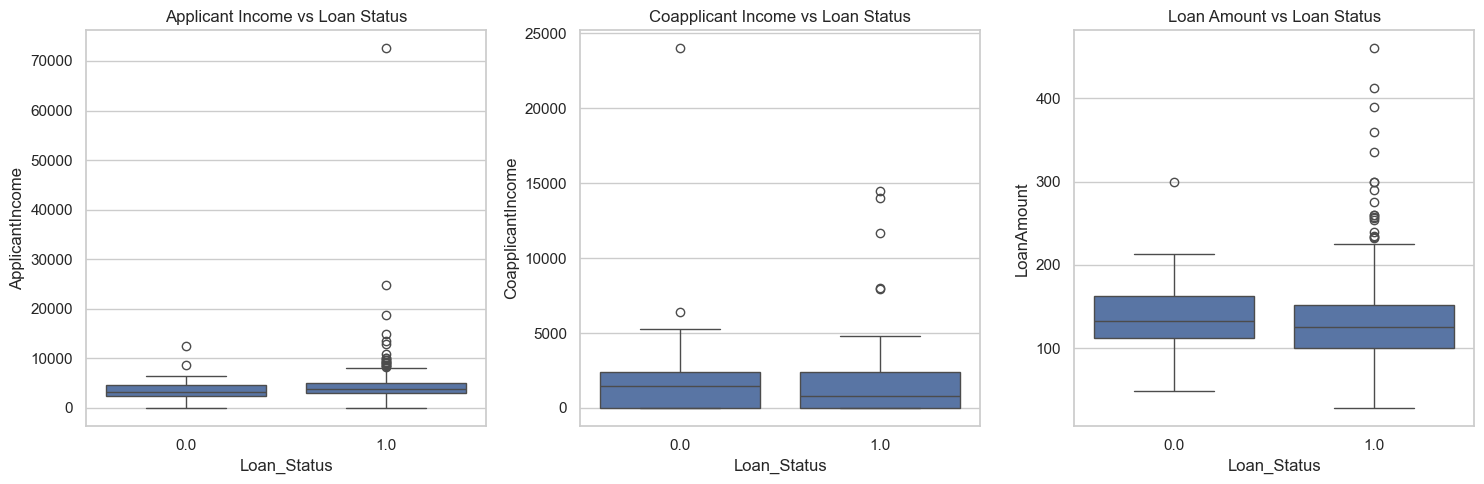

In [26]:
# Boxplots for continuous variables
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df_clean, ax=axes[0])
axes[0].set_title('Applicant Income vs Loan Status')
sns.boxplot(x='Loan_Status', y='CoapplicantIncome', data=df_clean, ax=axes[1])
axes[1].set_title('Coapplicant Income vs Loan Status')
sns.boxplot(x='Loan_Status', y='LoanAmount', data=df_clean, ax=axes[2])
axes[2].set_title('Loan Amount vs Loan Status')
plt.tight_layout()
plt.show()

Summary: 
* **Applicant Income vs Loan Status**: Median incomes are similar for approved and rejected loans; high income does not strongly predict approval.
* **Coapplicant Income vs Loan Status**: Income distributions are comparable with minor differences; coapplicant income is not a strong predictor.
* **Loan Amount vs Loan Status**: Approved loans have slightly higher amounts, but distributions largely overlap; loan amount alone is not a decisive factor.

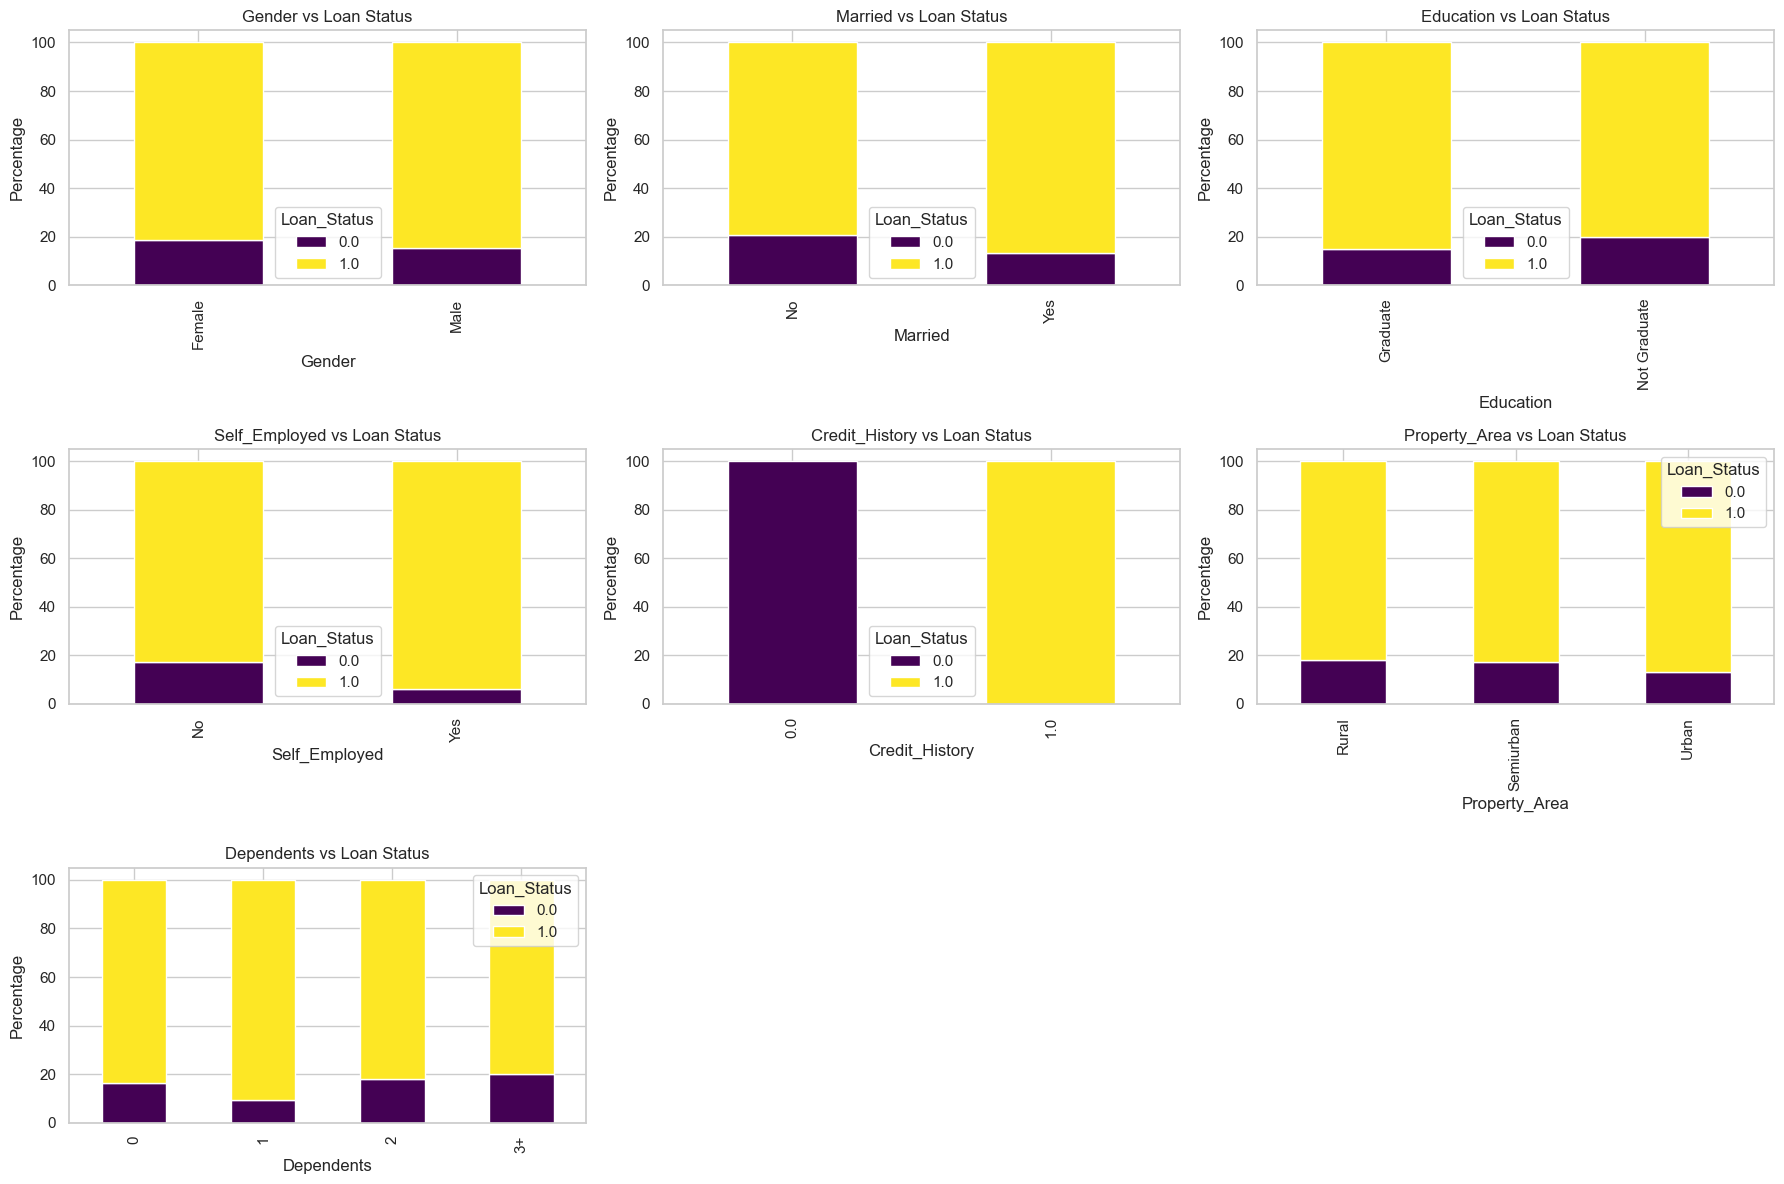

In [27]:
# Stacked bar plots for categorical variables
categorical_vars = ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Dependents']
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()
for i, var in enumerate(categorical_vars):
    ct = pd.crosstab(df_clean[var], df_clean['Loan_Status'], normalize='index') * 100
    ct.plot(kind='bar', stacked=True, ax=axes[i], colormap='viridis')
    axes[i].set_title(f'{var} vs Loan Status')
    axes[i].set_ylabel('Percentage')
    axes[i].legend(title='Loan_Status')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


**The stacked bar plots** provide valuable insights into how various categorical variables relate to loan approval outcomes. Among all features, credit history emerges as the most influential factor, with applicants having a positive credit history (value = 1.0) showing significantly higher approval rates, while those without it are mostly denied. Marital status and employment type also play a role, as married and non-self-employed individuals generally experience slightly higher approval rates. Gender, education, and property area show minimal influence, with loan approval rates being fairly consistent across categories. Lastly, number of dependents has a modest impact, where applicants with fewer dependents tend to have better chances of approval, possibly reflecting lower financial burden. Overall, while several demographic and financial attributes affect loan eligibility, credit history stands out as the most decisive factor

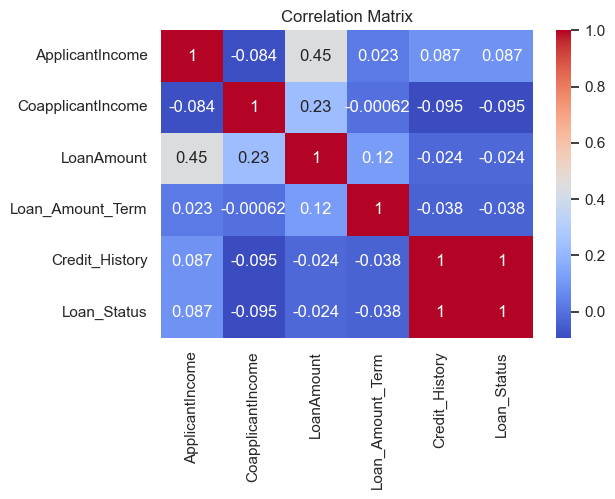

In [28]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**The heatmap** shows that LoanAmount is moderately correlated with ApplicantIncome (0.45) and slightly with CoapplicantIncome (0.23). Credit_History shows a very high correlation with Loan_Status, suggesting it’s a key factor in loan approval. Other variables have weak or negligible correlations with Loan_Status, indicating limited predictive power individually.

In [29]:
# Feature Importance using Random Forest
categorical_vars_rf = categorical_vars.copy()
df_encoded = df_clean.copy()
for col in categorical_vars_rf + ['Loan_Status']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
X_rf = df_encoded.drop(columns=['Loan_ID', 'Loan_Status'])
y_rf = df_encoded['Loan_Status']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_rf, y_rf)
importances = pd.Series(rf.feature_importances_, index=X_rf.columns).sort_values(ascending=False)
print("\nFeature Importances:\n", importances)



Feature Importances:
 Credit_History       0.801432
ApplicantIncome      0.066461
LoanAmount           0.044401
CoapplicantIncome    0.037398
Loan_Amount_Term     0.013207
Property_Area        0.009451
Dependents           0.007703
Education            0.005496
Married              0.005432
Gender               0.004831
Self_Employed        0.004188
dtype: float64


This output shows the feature importances computed by the Random Forest model, highlighting which variables have the most influence on loan approval predictions. The most important factor by far is Credit_History (importance = 0.80), indicating it's the strongest predictor of loan approval. Other numeric variables like ApplicantIncome, LoanAmount, and CoapplicantIncome have moderate influence, while categorical variables such as Property_Area, Dependents, and Education contribute less. Features like Gender and Self_Employed have minimal impact, suggesting they play a very small role in the model's decision-making.

### Train Logistic Regression model 

In [30]:
# Select relevant features
features = ['Credit_History', 'ApplicantIncome', 'LoanAmount', 'CoapplicantIncome', 'Property_Area', 'Dependents']
target = 'Loan_Status'
X = df_clean[features]
y = df_clean[target]

# Preprocessing for Logistic Regression
categorical_features = ['Credit_History', 'Property_Area', 'Dependents']
numerical_features = ['ApplicantIncome', 'LoanAmount', 'CoapplicantIncome']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ApplicantIncome',
                                                   'LoanAmount',
                                                   'CoapplicantIncome']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Credit_History',
                                                   'Property_Area',
                                                   'Dependents'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

### Model Prediction and Evaluation

In [31]:
# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        45

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58

Confusion Matrix:
 [[13  0]
 [ 0 45]]


The logistic regression model achieved perfect accuracy (1.00) on the test set of 58 samples, with flawless precision, recall, and F1-scores for both classes. The confusion matrix confirms zero misclassifications. Despite this excellent performance, further validation on larger or independent datasets is recommended to ensure generalizability.